# COMP3610 - Big Data - Project
Done by: Team 3 & A 1/2 Men

In [45]:
%pip install tensorflow keras spotipy

import re
import pickle
import random
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns

from os import path

from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyOAuth

from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.metrics import Accuracy, Precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

download(['wordnet', 'stopwords', 'punkt'])

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **Spotify Data Pre-processing**

In [ ]:
spotify_data = pd.read_csv("spotify_master.csv")

In [ ]:
spotify_data.describe()

,energy,key,tempo
count,1.204025e+06,1.204025e+06,1.204025e+06
mean,5.095363e-01,5.194151e+00,1.176344e+02
std,2.946839e-01,3.536731e+00,3.093705e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.520000e-01,2.000000e+00,9.405400e+01
50%,5.240000e-01,5.000000e+00,1.167260e+02
75%,7.660000e-01,8.000000e+00,1.370460e+02
max,1.000000e+00,1.100000e+01,2.489340e+02


In [ ]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1204025 non-null  object 
 1   name    1204022 non-null  object 
 2   energy  1204025 non-null  float64
 3   key     1204025 non-null  int64  
 4   tempo   1204025 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 45.9+ MB


Dropping features from the data `instrumentalness`, `liveness`, `time_signature`, `year`, `release_date`, `album_id`, `album`, `artist_ids`, `track_number`, `disc_number`, `explicit`, `danceability`, `acousticness`, `duration_ms`, `artists`, `mode`, `loudness`, `speechiness` and `valence`.

In summary, the most helpful features kept are: `id`, `energy` `key` and `tempo`

### Merge Timbre values scraped from the [Spotify Web API](https://developer.spotify.com/documentation/web-api)

In [ ]:
timbre_file = "spotify_tracks_timbre.csv"
timbre_data = pd.read_csv(timbre_file)

In [ ]:
# Drop all the HTTP status values
timbre_data = timbre_data.drop(['status'], axis=1)

In [ ]:
# Sum the timbre vector
def sum_timbre_vector(timbre):
    timbre = re.findall(r"[-+]?\d*\.\d+|\d+", timbre)
    timbre = [float(i) for i in timbre]
    return sum(timbre)

# Apply function on timbre column in df2
timbre_data['timbre'] = timbre_data['timbre'].apply(sum_timbre_vector)

In [ ]:
# Merge the two dataframes
spotify_data = pd.merge(spotify_data, timbre_data, on="id")
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42165 entries, 0 to 42164
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      42165 non-null  object 
 1   name    42165 non-null  object 
 2   energy  42165 non-null  float64
 3   key     42165 non-null  int64  
 4   tempo   42165 non-null  float64
 5   timbre  42165 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB


### Normalise Song Features
Note the following:
- The maximum possible key value is $11$ according to the [Spotify Web API Track Audio Features Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)
- The maximum possible timbre is $12$ (summation of values in 12-vector that range from $0 - 1$) according to the [Spotify Web API Track Audio Analysis Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis)
- The energy values are already in a normalised range of $0 - 1$
- The tempo column was chosen not to be normalised since we have no official documentation nor research that can provided a maximum tempo value. In fact, multiple sources indicate that the tempo of music is _indeed_ unbounded

In [ ]:
def normalise_timbre(timbre): return round((timbre / 12), 3)
def normalise_energy(energy): return round(energy, 3)
def normalise_key(key): return 0 if key <= 0 else round((key / 11), 3)

spotify_data['timbre'] = spotify_data['timbre'].apply(normalise_timbre)
spotify_data['energy'] = spotify_data['energy'].apply(normalise_energy)
spotify_data['key']    = spotify_data['key'].apply(normalise_key)
MAX_TEMPO = spotify_data['tempo'].max()

In [ ]:
spotify_data = spotify_data.drop(columns=['name'])

In [ ]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42165 entries, 0 to 42164
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      42165 non-null  object 
 1   energy  42165 non-null  float64
 2   key     42165 non-null  float64
 3   tempo   42165 non-null  float64
 4   timbre  42165 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.6+ MB


In [ ]:
spotify_data.describe()

,energy,key,tempo,timbre
count,42165.000000,42165.000000,42165.000000,42165.000000
mean,0.508722,0.494586,117.625541,0.499633
std,0.295462,0.310811,30.912038,0.230506
min,0.000000,0.000000,0.000000,0.085000
25%,0.251000,0.182000,94.133000,0.313000
50%,0.523000,0.545000,116.559000,0.481000
75%,0.766000,0.818000,137.023000,0.659000
max,1.000000,1.000000,222.859000,1.000000


### Initial Visualisations of Various Features vs. Tempo

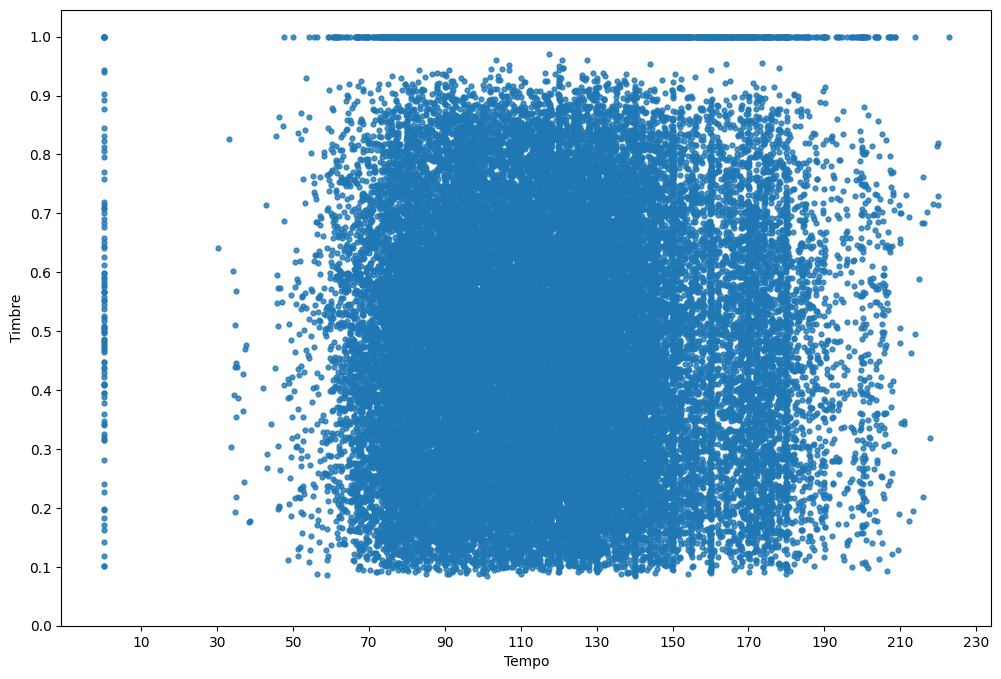

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

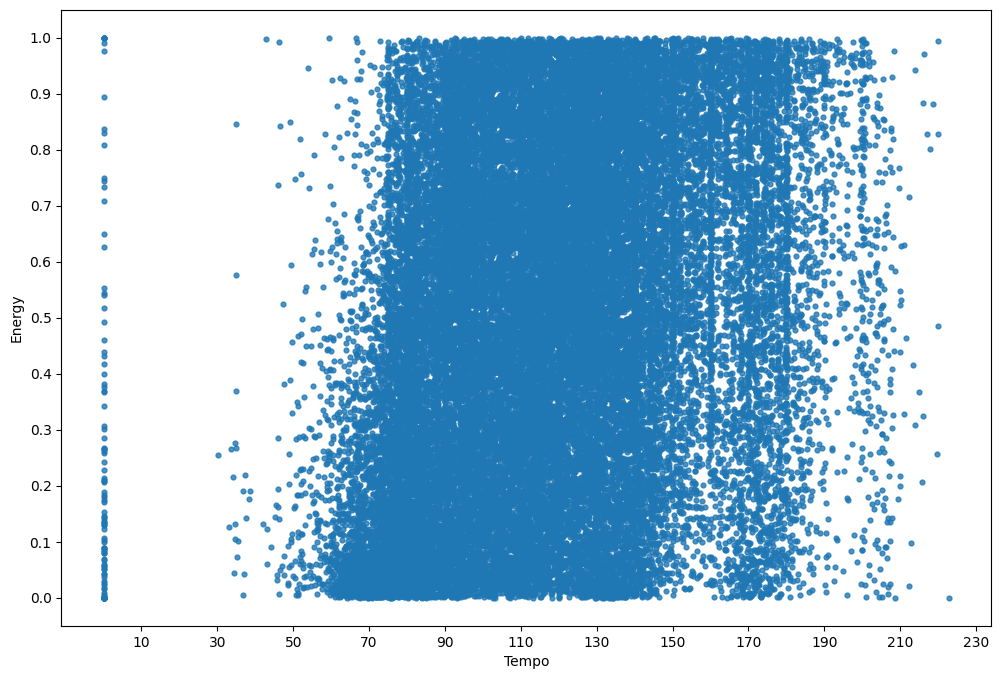

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['energy'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Energy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

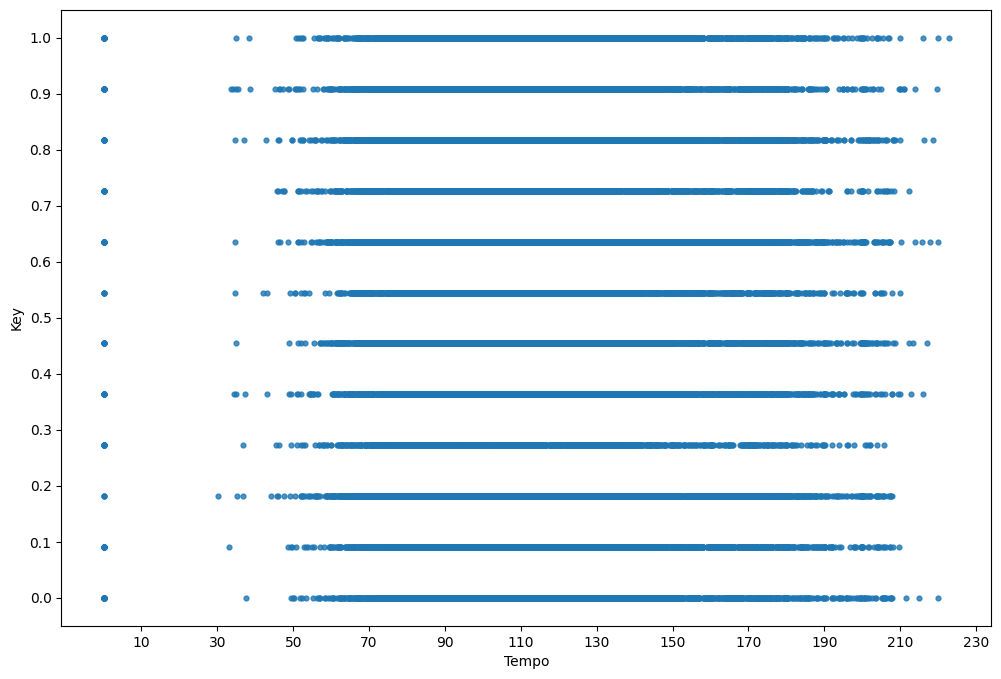

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['key'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Key')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### Justifying Outlier Removal in Tempo Column
We can see that there are consistent outliers in the dataset's tempo values: values less than 10 can be safely eradicated since there exists a clear disparity between tempo values less than 10 and those greater than 10

In [ ]:
tempo_outliers = np.where(spotify_data['tempo'] <= 10)
spotify_data = spotify_data.drop(tempo_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

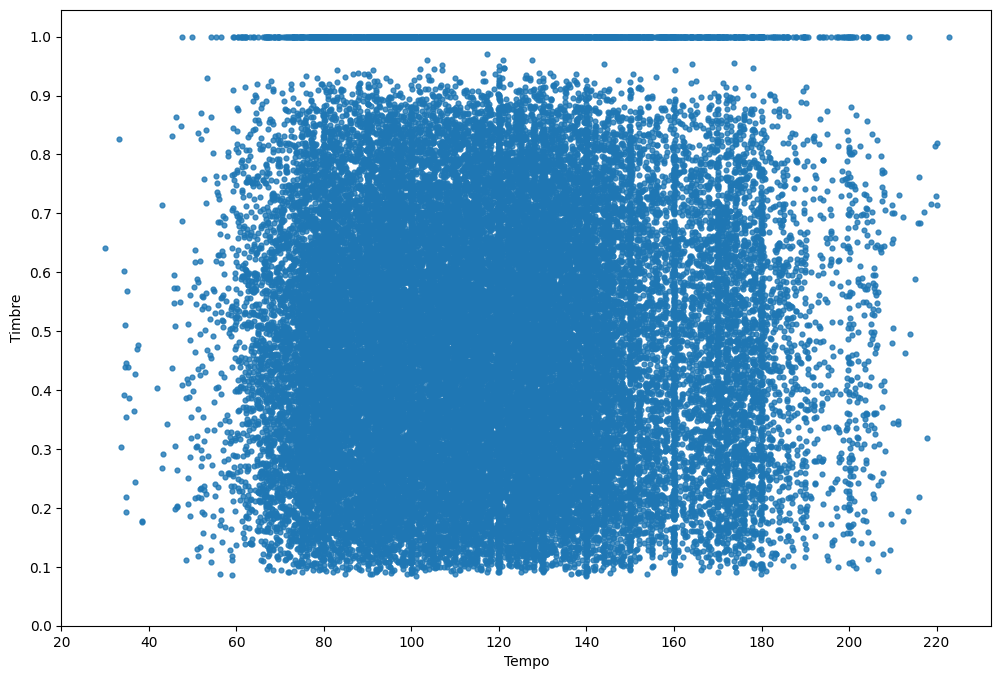

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### Justifying Outlier Removal in Timbre Column
We can observe that there seem to be a value of 1 for timbre vectors that are set to the default state (no data available). As such, these datapoints will be dropped.

In addition, the timbre values that are less than 0.05 seem to add no relative value to the main data cluster. Resultantly, they will also be removed

In [ ]:
timbre_outliers = np.where((spotify_data['timbre'] <= 0.05) | (spotify_data['timbre'] == 1.0))
spotify_data = spotify_data.drop(timbre_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

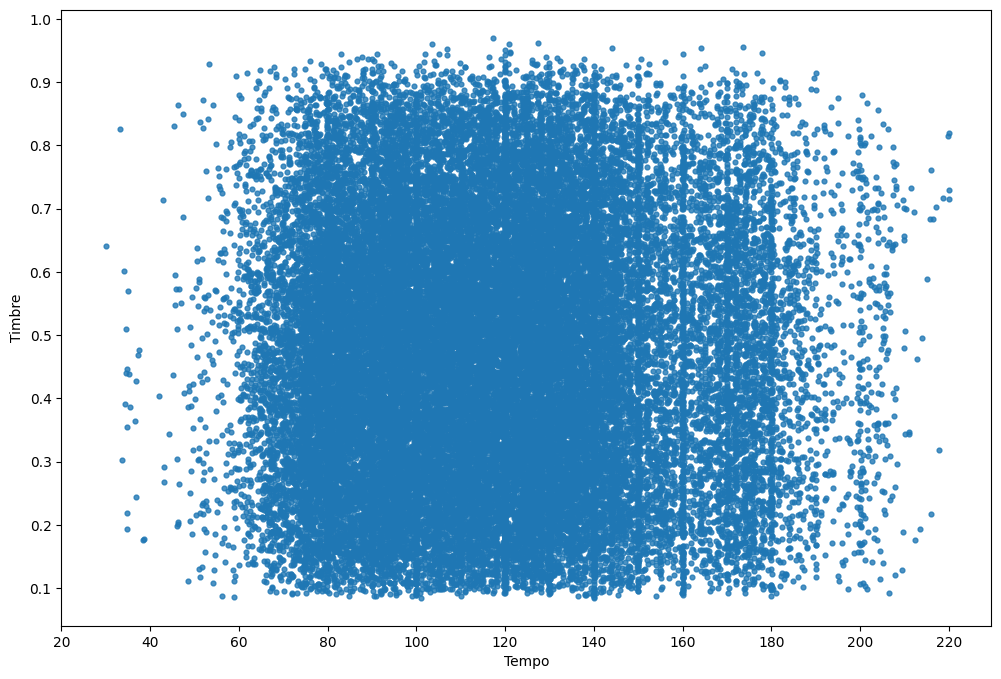

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.show()

### Visualising Tempo vs Key

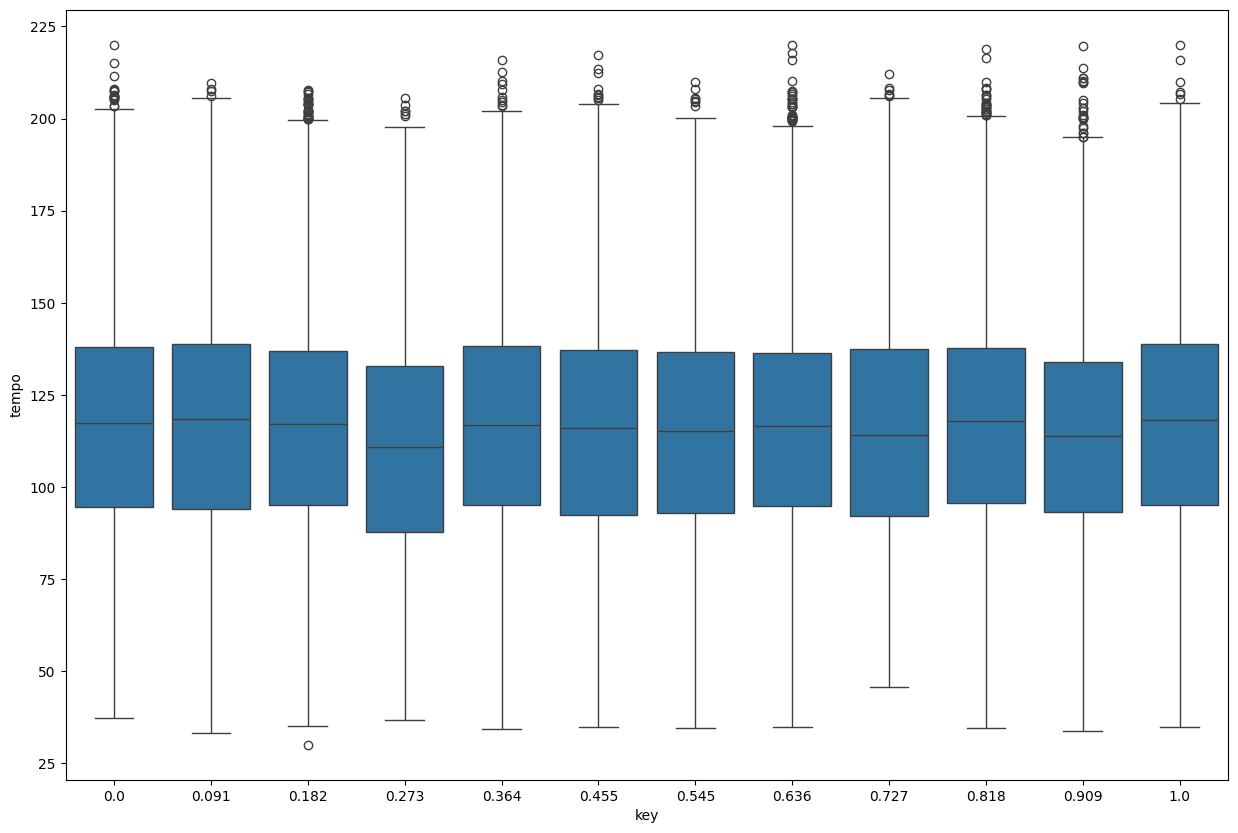

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x=spotify_data['key'], y=spotify_data['tempo'])
plt.xticks(np.arange(0, 12, 1))
plt.show()

## **Music Mood Classification**

### Extracting Ideal Cases in Spotify Dataset
According to [research](https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/), the following ranges were extrapolated from mean values of the features that indicate a particular mood. We have decided to fine tune these ranges such that they are able to detect and classify a substantial number of songs per mood.

In [ ]:
features = {
    "energy" : 0,
    "timbre" : 1,
    "key"    : 2,
    "tempo"  : 3
}

moods = {
  "Happy":       [(0.4, 0.6), (0.3, 0.5), (0.7, 1.0), (175, MAX_TEMPO)],
  "Exuberant":   [(0.6, 0.8), (0.3, 0.5), (0.6, 0.7), (160, 175)],
  "Energetic":   [(0.8, 1.0), (0.3, 0.5), (0.4, 0.6), (160, 175)],
  "Frantic":     [(0.6, 0.8), (0.6, 1.0), (0.2, 0.4), (175, MAX_TEMPO)],
  "Sad":         [(0.4, 0.6), (0.0, 0.2), (0.0, 0.2), (75,  100)],
  "Depression":  [(0.2, 0.4), (0.2, 0.3), (0.2, 0.4), (75,  100)],
  "Calm":        [(0.0, 0.2), (0.0, 0.2), (0.4, 0.6), (0,    75)],
  "Contentment": [(0.2, 0.4), (0.2, 0.3), (0.6, 0.7), (75,  100)]
}

Using the above ranges to pull out 'ideal' cases

In [ ]:
ideal_cases = {
  "Happy" : [],
  "Exuberant" : [],
  "Energetic" : [],
  "Frantic" : [],
  "Sad" : [],
  "Depression" : [],
  "Calm" : [],
  "Contentment" : []
}

def check_range(value: float, range): return range[0] <= value < range[1]

# Pull ideal cases from data file
for idx, row in enumerate(spotify_data.index):
    for mood in ideal_cases.keys():
        if check_range(spotify_data['energy'][idx], moods[mood][features['energy']]) and \
           check_range(spotify_data['timbre'][idx], moods[mood][features['timbre']]) and \
           check_range(spotify_data['key'][idx],    moods[mood][features['key']])    and \
           check_range(spotify_data['tempo'][idx],  moods[mood][features['tempo']]):
            ideal_cases[mood].append(spotify_data.iloc[idx])

# Generate new sample points
max_points = 70
test_data  = spotify_data.drop(columns=["id"])
for mood in ideal_cases.keys():
    print(f"Added {max_points - len(ideal_cases[mood])} to {mood} category")
    for x in range(0, max_points - len(ideal_cases[mood])):
        rand_energy = round(random.uniform(moods[mood][features['energy']][0], moods[mood][features['energy']][1]), 3)
        rand_timbre = round(random.uniform(moods[mood][features['timbre']][0], moods[mood][features['timbre']][1]), 3)
        rand_key    = round(random.uniform(moods[mood][features['key']][0],    moods[mood][features['key']][1]), 3)
        rand_tempo  = np.random.randint(moods[mood][features['tempo']][0],  moods[mood][features['tempo']][1])
        df = pd.DataFrame(columns=test_data.columns, data=[[rand_energy, rand_key, rand_tempo, rand_timbre]])
        ideal_cases[mood].append(df.iloc[0])

print("Total number of samples per mood:", len(ideal_cases['Happy']))

Added 46 to Happy category
Added 55 to Exuberant category
Added 31 to Energetic category
Added 60 to Frantic category
Added 1 to Sad category
Added 30 to Depression category
Added 50 to Calm category
Added 18 to Contentment category
Total number of samples per mood: 70


In [ ]:
ideal_cases_df = pd.concat([pd.DataFrame(ideal_cases[mood], columns=spotify_data.columns) for mood in ideal_cases.keys()])
ideal_cases_df['mood'] = [mood for mood in ideal_cases.keys() for _ in range(len(ideal_cases[mood]))]
ideal_cases_df = ideal_cases_df.reset_index(drop=True)
ideal_cases_df = ideal_cases_df.drop(columns=['id'])

### Visualisation of Clustering Behaviour of Ideal Cases

The music is organised into 8 categories: `Happy`, `Exuberant`, `Energetic`, `Frantic`, `Sad`, `Depression`, `Calm`, `Contentment`

We will now extract data points that match the exact ranges that define each of these categories

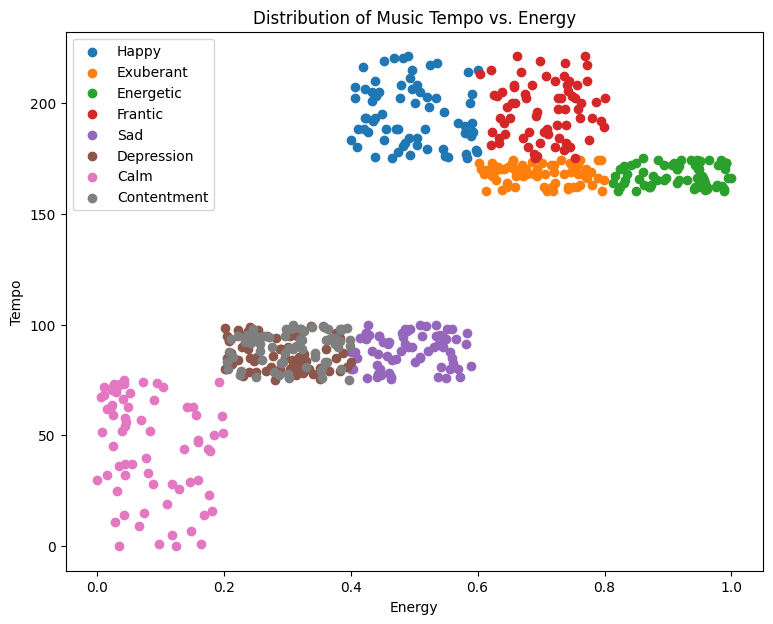

In [ ]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['energy'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Energy')
plt.show()

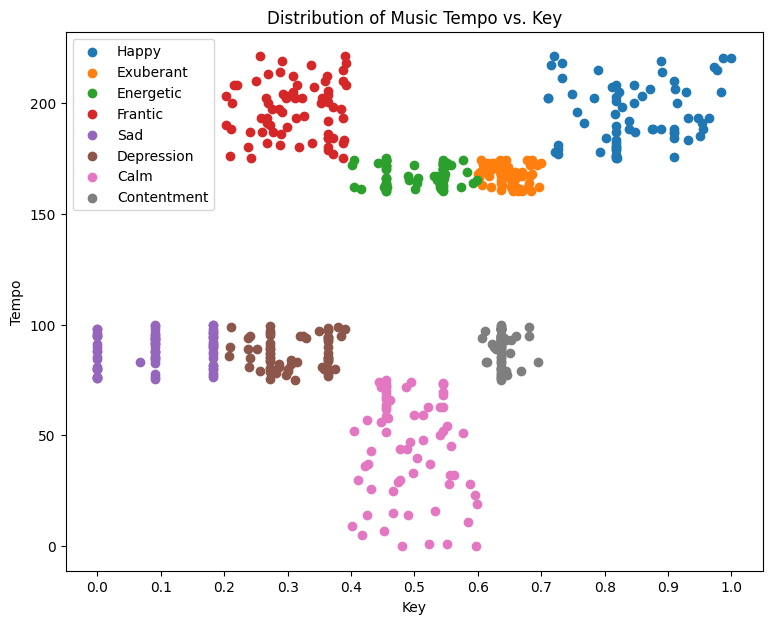

In [ ]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['key'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Key')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Key')
plt.show()


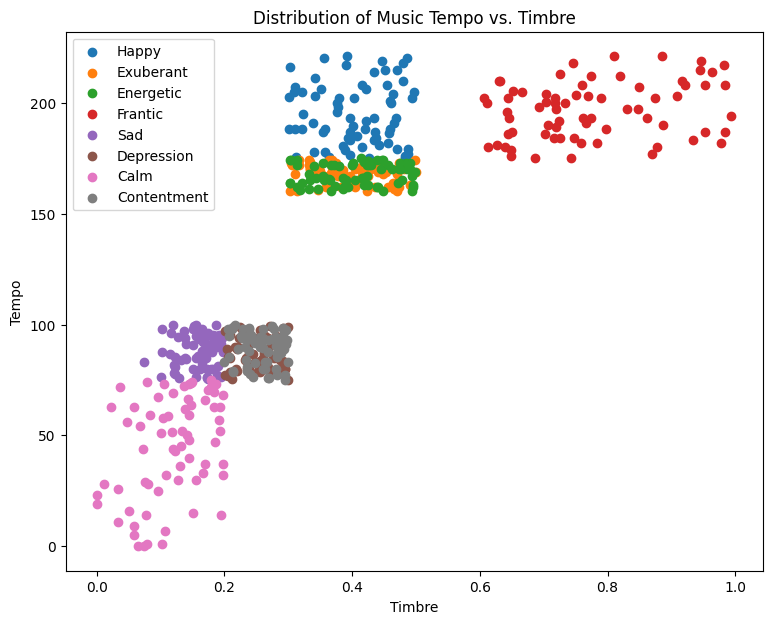

In [ ]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['timbre'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Timbre')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Timbre')
plt.show()

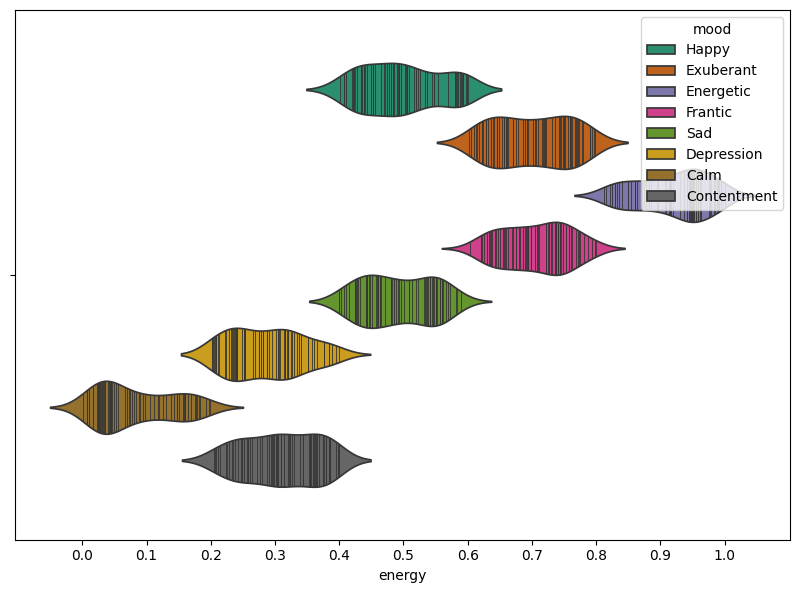

In [ ]:
figsize = (10, 0.86 * len(ideal_cases_df['mood'].unique()))
plt.figure(figsize=figsize)
plt.xticks(np.arange(0, 1.1, 0.1))
sns.violinplot(ideal_cases_df, x='energy', hue='mood', inner='stick', palette='Dark2')
plt.show()

### Support Vector Machine (SVM) for Music Mood Classification

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
svm_clf = LinearSVC(max_iter=150000, random_state=31)

# Separate features and target
X = ideal_cases_df.drop('mood', axis=1)
y = ideal_cases_df['mood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [ ]:
# Train the model
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9017857142857143


In [ ]:
# Save model to pickle file
with open("music_svm_model.pkl", "wb") as f: pickle.dump(svm_clf, f)

In [ ]:
tests = {
  'Happy 1'       : {'energy':0.79, 'key':0.45, 'tempo':100, 'timbre':0.30},    # Bastille - happier
  'Happy 2'       : {'energy':0.76, 'key':0.45, 'tempo':160, 'timbre':0.52},    # pharrell williams - happy
  'Sad 1'         : {'energy':0.39, 'key':0.00, 'tempo':134, 'timbre':0.24},    # xxxtentacion - jocelyn flores
  'Sad 2'         : {'energy':0.81, 'key':0.64, 'tempo':104, 'timbre':0.14},    # green day - when sept ends
  'Energetic 1'   : {'energy':0.97, 'key':0.70, 'tempo':142, 'timbre':0.33},    # marshmello - check this out
  'Energetic 2'   : {'energy':0.67, 'key':0.64, 'tempo':159, 'timbre':0.23},    # Marimba - Gangnam Style
  'Energetic 3'   : {'energy':0.87, 'key':0.73, 'tempo':130, 'timbre':0.79},    # YOASOBI - racing into the night
  'Exuberant'     : {'energy':0.96, 'key':0.50, 'tempo':160, 'timbre':0.84},    # ke$ha, pitbull - timbre
  'Contentment 1' : {'energy':0.45, 'key':0.75, 'tempo':89,  'timbre':0.81},    # UB40 - red red wine
  'Contentment 2' : {'energy':0.35, 'key':0.27, 'tempo':144, 'timbre':0.38},    # Vancouver Sleep Clinic - 405
  'Depression'    : {'energy':0.32, 'key':0.64, 'tempo':148, 'timbre':0.26}     # skylar grey - words
}

# Predict examples
for key, value in tests.items():
    predicted_mood = svm_clf.predict(pd.DataFrame([value]))
    print("Acutal Song Mood:",key,f"{(14 - len(key)) * ' '}","Predicted Mood:",predicted_mood[0])

Acutal Song Mood: Happy 1         Predicted Mood: Energetic
Acutal Song Mood: Happy 2         Predicted Mood: Energetic
Acutal Song Mood: Sad 1           Predicted Mood: Sad
Acutal Song Mood: Sad 2           Predicted Mood: Energetic
Acutal Song Mood: Energetic 1     Predicted Mood: Energetic
Acutal Song Mood: Energetic 2     Predicted Mood: Exuberant
Acutal Song Mood: Energetic 3     Predicted Mood: Contentment
Acutal Song Mood: Exuberant       Predicted Mood: Energetic
Acutal Song Mood: Contentment 1   Predicted Mood: Contentment
Acutal Song Mood: Contentment 2   Predicted Mood: Depression
Acutal Song Mood: Depression      Predicted Mood: Happy


In [ ]:
y_pred_all = svm_clf.predict(spotify_data.drop(columns=['id']))
spotify_data['mood'] = y_pred_all

In [ ]:
spotify_data.to_csv("classified_spotify_data.csv", index=False)

### Visualise Distribution of Music Categorisation

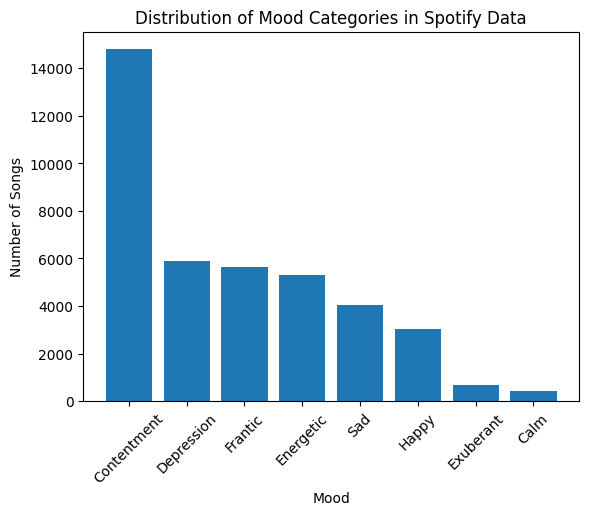

In [ ]:
# Count the number of songs in each mood category
mood_counts = spotify_data['mood'].value_counts()

# Create a bar chart of the mood counts
plt.bar(mood_counts.index, mood_counts.values)
plt.xlabel('Mood')
plt.ylabel('Number of Songs')
plt.title('Distribution of Mood Categories in Spotify Data')
plt.xticks(rotation=45)
plt.show()


### Visualise SVC Boundary Surface Conditions

In [ ]:
label_map = {
  'Happy': 0,
  'Exuberant': 1,
  'Energetic': 2,
  'Frantic': 3,
  'Sad': 4,
  'Depression': 5,
  'Calm': 6,
  'Contentment': 7
}
y = [label_map[x] for x in y]

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float64)
    out = ax.contourf(xx, yy, Z, **params)
    return out

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)
Xreduced = Xreduced.astype(np.float64)

In [ ]:
# Fit SVM to PCA reduced data
svm_clf.fit(Xreduced, y)

LinearSVC(max_iter=150000, random_state=31)

<Figure size 1100x900 with 0 Axes>

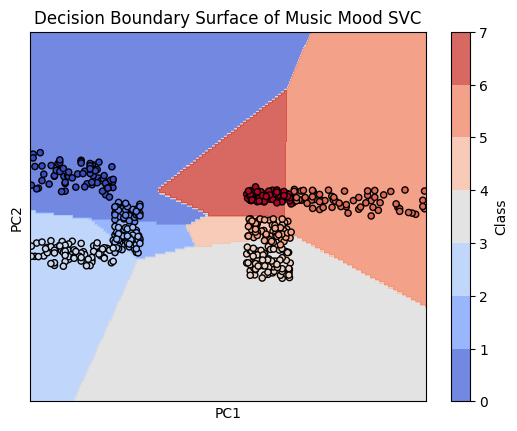

In [ ]:
plt.figure(figsize=(11, 9))

fig, ax = plt.subplots()
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
out = plot_contours(ax, svm_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# Add a colorbar
plt.colorbar(out, label='Class')

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decision Boundary Surface of Music Mood SVC')
plt.show()

## **Google Emotions Data Pre-processing**

In [27]:
df = pd.read_csv('data/go_emotions_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    211225 non-null  object
 1   text                  211225 non-null  object
 2   example_very_unclear  211225 non-null  bool  
 3   admiration            211225 non-null  int64 
 4   amusement             211225 non-null  int64 
 5   anger                 211225 non-null  int64 
 6   annoyance             211225 non-null  int64 
 7   approval              211225 non-null  int64 
 8   caring                211225 non-null  int64 
 9   confusion             211225 non-null  int64 
 10  curiosity             211225 non-null  int64 
 11  desire                211225 non-null  int64 
 12  disappointment        211225 non-null  int64 
 13  disapproval           211225 non-null  int64 
 14  disgust               211225 non-null  int64 
 15  embarrassment    

### Initial Trimming of Useless Columns

In [28]:
df = df[df['example_very_unclear'] == False]
df = df[df['neutral']              == False]
df = df[df['disgust']              == False]
df = df[df['desire']               == False]
df = df[df['anger']                == False]
df = df[df['annoyance']            == False]
df = df[df['confusion']            == False]
df = df[df['embarrassment']        == False]
df = df[df['approval']             == False]
df = df[df['disapproval']          == False]
df = df[df['surprise']             == False]
df = df.drop(columns=['id', 'example_very_unclear', 'neutral', 'disgust', 'desire', 'anger', 'annoyance', 'confusion', 'embarrassment', 'approval', 'disapproval', 'surprise'])
df

,text,admiration,amusement,caring,curiosity,disappointment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness
0,That game hurt.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,That's crazy; I went to a super [RELIGION] hig...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,that's adorable asf,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211218,"Thanks, [NAME]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
211219,"Well, I'm glad you're out of all that now. How...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
emotions_map = {
    "calm":        ["relief"],
    "energetic":   ["excitement"],
    "frantic":     ["fear"],
    "exuberant":   ["amusement"],
    "happy":       ["joy"],
    "sad":         ["sadness"],
    "depression":  ["grief", "remorse"],
    "contentment": ["gratitude"]
}

for emotion in emotions_map.keys(): df[emotion] = None

In [30]:
for index, row in df.iterrows():
    for emotion in emotions_map:
        x = emotions_map[emotion]
        df.at[index, emotion] = 1 if sum((df.at[index, x[i]]) for i in range(0, len(x))) >= 1 else 0

In [31]:
calm_count        = df[df['calm']        == 1]['calm'].sum()
energetic_count   = df[df['energetic']   == 1]['energetic'].sum()
frantic_count     = df[df['frantic']     == 1]['frantic'].sum()
exuberant_count   = df[df['exuberant']   == 1]['exuberant'].sum()
happy_count       = df[df['happy']       == 1]['happy'].sum()
sad_count         = df[df['sad']         == 1]['sad'].sum()
depression_count  = df[df['depression']  == 1]['depression'].sum()
contentment_count = df[df['contentment'] == 1]['contentment'].sum()
print('Calm:', calm_count)
print('Energetic:', energetic_count)
print('Frantic:', frantic_count)
print('Exuberant:', exuberant_count)
print('Happy:', happy_count)
print('Sad:', sad_count)
print('Depression:', depression_count)
print('Contentment:', contentment_count)

Calm: 1125
Energetic: 4958
Frantic: 2691
Exuberant: 8079
Happy: 7185
Sad: 5840
Depression: 2677
Contentment: 10275


### Rationale for dropping rest of columns
The columns identified below were used to generate the mood cluster columns (calm, energetic, frantic, exuberant, happy, sad, depression, contentment). Due to the mood cluster columns being used for further analysis, the columns used to create it were not required, thus accounting for removal.

In [32]:
columns_to_keep = [
    'text', 'calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad',
    'depression', 'contentment'
]
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = df.drop(columns=columns_to_drop)

In [33]:
columns_to_check = ['calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad', 'depression', 'contentment']
df = df[df[columns_to_check].sum(axis=1) != 0]
df = df.reset_index(drop=True)

In [34]:
df

,text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,That game hurt.,0,0,0,0,0,1,0,0
1,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1
2,That's crazy; I went to a super [RELIGION] hig...,0,0,0,1,0,0,0,0
3,that's adorable asf,0,0,0,1,0,0,0,0
4,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
39636,Oh wow My heart ✨,0,1,0,0,0,0,0,0
39637,Thanks a [NAME],0,0,0,0,0,0,0,1
39638,What a great photo and you two look so happy. 😍,0,0,0,0,1,0,0,0
39639,"Thanks, [NAME]",0,0,0,0,0,0,0,1


### Google Emotions Dataset Text Cleaning

In [35]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text: str):
    text   = text.lower()
    text   = text.replace("[religion]", "").replace("[name]", "")
    text   = re.sub(r'[^a-z\'\s]', ' ' , text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemma_tokens    = [lemmatizer.lemmatize(word) if len(word) > 4 else word for word in filtered_tokens]
    return ' '.join(lemma_tokens)

In [36]:
cleaned_df = pd.DataFrame(df)

In [37]:
cleaned_df['cleaned_text'] = cleaned_df['text'].apply(clean_text)

In [38]:
cleaned_df = cleaned_df.drop('text', axis=1)
cleaned_df = cleaned_df[['cleaned_text', 'calm', 'energetic', 'frantic' ,'exuberant', 'happy', 'sad', 'depression', 'contentment']]
cleaned_df

,cleaned_text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,game hurt,0,0,0,0,0,1,0,0
1,right considering important document know damn...,0,0,0,0,0,0,0,1
2,'s crazy went super high school think remember...,0,0,0,1,0,0,0,0
3,'s adorable asf,0,0,0,1,0,0,0,0
4,sponge blurb pubs quaw haha gurr ha aaa finale...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
39636,oh wow heart,0,1,0,0,0,0,0,0
39637,thanks,0,0,0,0,0,0,0,1
39638,great photo two look happy,0,0,0,0,1,0,0,0
39639,thanks,0,0,0,0,0,0,0,1


### Reverse One-Hot on Google Emotions Dataset

In [39]:
def determine_class(row):
    if row['calm'] == 1:       return 'calm'
    if row['energetic'] == 1:  return 'energetic'
    if row['frantic'] == 1:    return 'frantic'
    if row['exuberant'] == 1:  return 'exuberant'
    if row['happy'] == 1:      return 'happy'
    if row['sad'] == 1:        return 'sad'
    if row['depression'] == 1: return 'depression'
    return 'contentment'

In [40]:
# prompt: Ensure all rows have a class label. If not, drop the row

cleaned_df = cleaned_df[cleaned_df.apply(determine_class, axis=1).notnull()]


In [41]:
cleaned_df['class'] = None
for index, row in df.iterrows():
    cleaned_df.at[index, 'class'] = determine_class(row)

In [42]:
calm        = cleaned_df[cleaned_df['class'] == 'calm']
energetic   = cleaned_df[cleaned_df['class'] == 'energetic']
frantic     = cleaned_df[cleaned_df['class'] == 'frantic']
exuberant   = cleaned_df[cleaned_df['class'] == 'exuberant']
happy       = cleaned_df[cleaned_df['class'] == 'happy']
sad         = cleaned_df[cleaned_df['class'] == 'sad']
depression  = cleaned_df[cleaned_df['class'] == 'depression']
contentment = cleaned_df[cleaned_df['class'] == 'contentment']

In [43]:
cleaned_df = shuffle(cleaned_df)

In [50]:
calm = calm.head(depression.shape[0])
energetic = energetic.head(depression.shape[0])
frantic = frantic.head(depression.shape[0])
exuberant = exuberant.head(depression.shape[0])
happy = happy.head(depression.shape[0])
sad = sad.head(depression.shape[0])
contentment = contentment.head(depression.shape[0])

balanced_df = pd.concat([calm,energetic,frantic,exuberant,happy,sad,contentment,depression])
balanced_df = shuffle(balanced_df)
# X, y = balanced_df['cleaned_text'], balanced_df['class']
X, y = cleaned_df['cleaned_text'], cleaned_df['class']

## **Emotion Detection**

1. Logistic Regression Model + TFIDF
2. Logistic Regression Model + TFIDF + Ngram
3. Recurrent Neural Network (RNN) using Long-Short Term Memory (LSTM)



In [51]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_ngram = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))
logit = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=25000, random_state=937, n_jobs=8)

def text_fit(X, y, model, clf_model):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'Model f1: {f1}')
    print(f"Precision: {precision}")

### 1. Logit Model + TFIDF

In [52]:
text_fit(X, y, tfidf, logit)

# features: 14809
# train records: 29730
# test records: 9911
Model f1: 0.5624812692678953
Precision: 0.6163277328398828


### 2. Logit Model + TFIDF + Ngram

In [ ]:
text_fit(X, y, tfidf_ngram, logit)

# features: 194853
# train records: 34091
# test records: 11364
Model f1: 0.4286071646094187
Precision: 0.5778755506279312


### 3. Recurrent Neural Network using Long-Short Term Memory (LSTM)

In [7]:
EMBEDDING_DIM = 248  # Dimensionality of word embeddings

# Assign data points and labels
text_data = cleaned_df['cleaned_text'].values
emotion_labels = cleaned_df[emotions_map.keys()].values

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

# Pad sequences
maxlen = np.max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# Get vocab size
vocab_size = len(tokenizer.word_index) + 1

NameError: name 'cleaned_df' is not defined

In [82]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, emotion_labels, test_size=0.2, random_state=42)

# Force type as float32 for Numpy-Tensor conversion
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [6]:
# Define custom layer for LSTM Cells
LSTM_CELLS = [
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(64)),
    Dense(8, activation='softmax')
]

# Define the LSTM model
model = Sequential(LSTM_CELLS)

NameError: name 'vocab_size' is not defined

In [85]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

# Train the model (replace with actual training data)
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.5)

496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 1.7199 - precision: 0.8241 - val_loss: 1.2629 - val_precision: 0.8130


In [25]:
model.save("models/test.h5")

NameError: name 'model' is not defined

## **Connect Emotion Detection with Music Mood Classifier**

### Model Loading and Data Capturing

In [56]:
def label_to_emotion(label: int) -> str:
    x = list(emotions_map.keys())[label]
    return str(x)[0].upper() + x[1:]

Load the pre-trained model so we can run evaluation on it

In [46]:
from tensorflow.keras.models import load_model

loaded_model = load_model("models/test.keras")

c:\Users\kesha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 20 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['kernel', 'recurrent_kernel', 'bias']

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>]

Now, we can use the pre-trained model for evaulation

In [ ]:
test_data = ["beach party with friends"]
test_seq = tokenizer.texts_to_sequences(clean_text(test_data[0]))
test_padded_seq = pad_sequences(test_seq, maxlen=maxlen)
model_prediction = loaded_model.predict(test_padded_seq)
predicted_emotion = label_to_emotion(np.argmax(model_prediction[0]))

print(f"Input: {test_data[0]}")
print("Predicted emotion:", predicted_emotion)

1/1 [==============================] - 0s 33ms/step
Input: beach party with friends
Predicted emotion: Exuberant


In [ ]:
music_data = pd.read_csv('classified_spotify_data.csv')
music_data.head(5)

,id,energy,key,tempo,timbre,mood
0,5Ix60J0iq2dVmwd3L9qEER,0.982,0.182,118.207,0.365,Energetic
1,6ABVgQIet4qRgLbwdBfAWz,0.203,0.000,72.024,0.468,Depression
2,7sEQzQVOjBCQc2sDCzhnYf,0.426,0.000,122.040,0.770,Frantic
3,55R3scEMn7riTl00Zja6On,0.919,0.818,159.907,0.604,Contentment
4,2mJsP3AWoshhb2t2SXczAw,0.448,1.000,132.155,0.327,Contentment


### Playlist Curation

In [2]:
shuffled_songs = music_data[music_data['mood'] == predicted_emotion].sample(frac=1).reset_index(drop=True)
shuffled_songs.head(5)

NameError: name 'music_data' is not defined

In [ ]:
candidate_songs = shuffled_songs.head(100)

In [1]:
SPOTIPY_CLIENT_ID = '24432fee68ea464c94ed2eeaff451fea'
SPOTIPY_CLIENT_SECRET = '5a4e797fab984adb9375ee8c6b9fab95'
spotify = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        scope="playlist-modify-public",
        client_id=SPOTIPY_CLIENT_ID,
        client_secret=SPOTIPY_CLIENT_SECRET,
        redirect_uri="n/a"
    )
)

NameError: name 'spotipy' is not defined

In [529]:
sp_user = spotify.current_user()
# user_name = sp_user['uri'].split(":")[2]
# playlist_name = predicted_emotion + " Playlist"

# print(user_name)


# playlist = spotify.user_playlist_create(
#     user=f"{user_name}",
#     name=f"{playlist_name}",
#     public=False,
#     description="A playlist curated just for yoy based on your current mood",
#     collaborative=False
# )
# print(playlist)

KeyboardInterrupt: Interrupted by user